- [논문](https://arxiv.org/pdf/1708.05031.pdf)
- [저자 코드](https://github.com/hexiangnan/neural_collaborative_filtering)
- 두가지 방식
    - 논문 방식 : 0과 1로 user-item interaction으로 matrix을 나타내고 학습
    - 다른 방식 : rating을 직접 예측하고, loss를 구해보는 것

- 아래의 코드는 rating을 예측

- 논문:  user latent vector + item latent vector
- 새롭게 생각할 수 있는 방법: user latent vector + item latent vector + etc vector (예시) meta information 

In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

import math
from torch import nn, optim
import torch
import torch.nn.functional as F
from torch.autograd import Variable

from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

---

In [2]:
data_path = './movielens_data'

In [3]:
def read_data(data_path):
    df = pd.read_csv(os.path.join(data_path,'ratings.csv'))
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=1234, shuffle=True)
    return train_df, val_df

In [4]:
train_df, val_df = read_data(data_path)

In [5]:
print(train_df.shape)
train_df.head()

(80668, 4)


,userId,movieId,rating,timestamp
95713,600,5943,3.0,1237714356
61560,407,2571,5.0,1424349171
77204,482,8958,4.0,1105397126
93367,599,2322,2.5,1498515283
90892,590,2959,3.5,1258416553


In [6]:
val_df.shape

(20168, 4)

<AxesSubplot:>

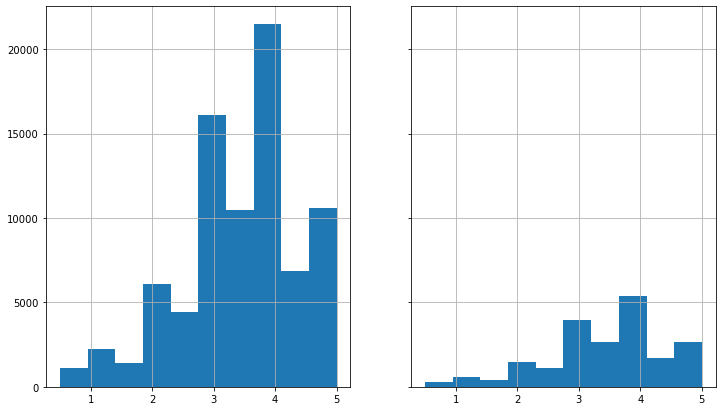

In [7]:
# 데이터의 편차가 심함
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(12,7))
ax = ax.ravel()

train_df['rating'].hist(ax=ax[0])
val_df['rating'].hist(ax=ax[1])

In [8]:
train_df['rating'].describe()

count    80668.000000
mean         3.503130
std          1.041525
min          0.500000
25%          3.000000
50%          3.500000
75%          4.000000
max          5.000000
Name: rating, dtype: float64

In [9]:
# Load all related dataframe
movies_df = pd.read_csv(os.path.join(data_path, 'movies.csv'), encoding='utf-8')
movies_df = movies_df.set_index('movieId')

In [10]:
movies_df

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy
...,...,...
193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
193585,Flint (2017),Drama


In [11]:
# 영화 데이터의 메타 정보를 확인한다
movieName_dict = movies_df.to_dict()['title']
genres_dict = movies_df.to_dict()['genres']

In [12]:
movies_df['genres']

movieId
1         Adventure|Animation|Children|Comedy|Fantasy
2                          Adventure|Children|Fantasy
3                                      Comedy|Romance
4                                Comedy|Drama|Romance
5                                              Comedy
                             ...                     
193581                Action|Animation|Comedy|Fantasy
193583                       Animation|Comedy|Fantasy
193585                                          Drama
193587                               Action|Animation
193609                                         Comedy
Name: genres, Length: 9742, dtype: object

In [13]:
class DatasetLoader:
    def __init__(self, data_path):
        self.train_df, val_temp_df = read_data(data_path)

        self.min_rating = min(self.train_df.rating)
        self.max_rating = self.train_df.rating.max()
        
        # 유저 dict
        self.unique_users = self.train_df.userId.unique()
        self.num_users = len(self.unique_users)
        self.user_to_index = {original: idx for idx, original in enumerate(self.unique_users)}
        
        # 아이템 dict
        self.unique_movies = self.train_df.movieId.unique()
        self.num_movies = len(self.unique_movies)
        self.movie_to_index = {original: idx for idx, original in enumerate(self.unique_movies)}

        self.val_df = val_temp_df[val_temp_df.userId.isin(self.unique_users) & val_temp_df.movieId.isin(self.unique_movies)]

    def generate_trainset(self):
        # user 0, 0, 0, 1,2, 3,3, -> movie: 0,0,0,0,0,0,
        X_train = pd.DataFrame({'user': self.train_df.userId.map(self.user_to_index),
                     'movie': self.train_df.movieId.map(self.movie_to_index)})
        y_train = self.train_df['rating'].astype(np.float32)

        return X_train, y_train

    def generate_valset(self):
        X_val = pd.DataFrame({'user': self.val_df.userId.map(self.user_to_index),
                              'movie': self.val_df.movieId.map(self.movie_to_index)})
        y_val = self.val_df['rating'].astype(np.float32)
        return X_val, y_val

In [14]:
class FeedForwardEmbedNN(nn.Module):

    def __init__(self, n_users, n_movies, hidden, dropouts, n_factors, embedding_dropout):
        super().__init__()
        self.user_emb = nn.Embedding(n_users, n_factors)
        self.movie_emb = nn.Embedding(n_movies, n_factors)
        self.drop = nn.Dropout(embedding_dropout)
        self.hidden_layers = nn.Sequential(*list(self.generate_layers(n_factors*2, hidden, dropouts)))
        self.fc = nn.Linear(hidden[-1], 1)

    def generate_layers(self, n_factors, hidden, dropouts):
        assert len(dropouts) == len(hidden)

        idx = 0
        while idx < len(hidden):
            if idx == 0:
                yield nn.Linear(n_factors, hidden[idx])
            else:
                yield nn.Linear(hidden[idx-1], hidden[idx])
            yield nn.ReLU()
            yield nn.Dropout(dropouts[idx])

            idx += 1

    def forward(self, users, movies, min_rating=0.5, max_rating=5):
        concat_features = torch.cat([self.user_emb(users), self.movie_emb(movies)], dim=1)
        x = F.relu(self.hidden_layers(concat_features))
        out = torch.sigmoid(self.fc(x))
        out = (out * (max_rating - min_rating)) + min_rating

        return out

    def predict(self, users, movies):
        # return the score
        output_scores = self.forward(users, movies)
        return output_scores

In [15]:
class BatchIterator:

    def __init__(self, X, y, batch_size=32, shuffle=True):
        X, y = np.asarray(X), np.asarray(y)

        if shuffle:
            index = np.random.permutation(X.shape[0])
            X, y = X[index], y[index]

        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n_batches = int(math.ceil(X.shape[0] // batch_size))
        self._current = 0

    def __iter__(self):
        return self

    def __next__(self):
        return self.next()

    def next(self):
        if self._current >= self.n_batches:
            raise StopIteration()
        k = self._current
        self._current += 1
        bs = self.batch_size
        return self.X[k * bs:(k + 1) * bs], self.y[k * bs:(k + 1) * bs]


In [16]:
def batches(X, y, bs=32, shuffle=True):
    for x_batch, y_batch in BatchIterator(X, y, bs, shuffle):
        x_batch = torch.LongTensor(x_batch)
        y_batch = torch.FloatTensor(y_batch)
        yield x_batch, y_batch.view(-1, 1)

In [17]:
def model_train(ds, config):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    X_train, y_train = ds.generate_trainset()
    X_valid, y_valid = ds.generate_valset()
    print(f'TrainSet Info: {ds.num_users} users, {ds.num_movies} movies')

    model = FeedForwardEmbedNN(
        n_users=ds.num_users, n_movies=ds.num_movies,
        n_factors=config['num_factors'], hidden=config['hidden_layers'],
        embedding_dropout=config['embedding_dropout'], dropouts=config['dropouts']
    )
    model.to(device)

    batch_size = config['batch_size']
    num_epochs = config['num_epochs']
    max_patience = config['total_patience']
    num_patience = 0
    best_loss = np.inf

    criterion = nn.MSELoss(reduction='sum')
    criterion.to(device)
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])

    result = dict()
    for epoch in tqdm(range(num_epochs)):
        training_loss = 0.0
        for batch in batches(X_train, y_train, shuffle=True, bs=batch_size):
            x_batch, y_batch = [b.to(device) for b in batch]
            optimizer.zero_grad()
            with torch.set_grad_enabled(True):
                outputs = model(x_batch[:, 0], x_batch[:, 1], ds.min_rating, ds.max_rating)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
            training_loss += loss.item()
        result['train'] = training_loss / len(X_train)

        # Apply Early Stopping criteria and save best model params
        val_outputs = model(torch.LongTensor(X_valid.user.values).to(device),
                            torch.LongTensor(X_valid.movie.values).to(device), ds.min_rating, ds.max_rating)
        val_loss = criterion(val_outputs.to(device), torch.FloatTensor(y_valid.values).view(-1, 1).to(device))
        result['val'] = float((val_loss / len(X_valid)).data)

        if val_loss < best_loss:
            print('Save new model on epoch: %d' % (epoch + 1))
            best_loss = val_loss
            result['best_loss'] = val_loss
            torch.save(model.state_dict(), config['save_path'])
            num_patience = 0
        else:
            num_patience += 1

        print(f'[epoch: {epoch+1}] train: {result["train"]} - val: {result["val"]}')

        if num_patience >= max_patience:
            print(f"Early Stopped after epoch {epoch+1}")
            break

    return result

In [18]:
def model_valid(user_id_list, movie_id_list, data_path):
    dataset = DatasetLoader(data_path)
    processed_test_input_df = pd.DataFrame({
        'user_id': [dataset.user_to_index[x] for x in user_id_list],
        'movie_id': [dataset.movie_to_index[x] for x in movie_id_list]
    })

    # 학습한 모델 load하기 
    my_model = FeedForwardEmbedNN(dataset.num_users, dataset.num_movies,
                       config['hidden_layers'], config['dropouts'], config['num_factors'], config['embedding_dropout'])
    my_model.load_state_dict(torch.load('params.data'))
    prediction_outputs = my_model.predict(users=torch.LongTensor(processed_test_input_df.user_id.values),
                     movies=torch.LongTensor(processed_test_input_df.movie_id.values))

    return prediction_outputs

In [19]:
dataset = DatasetLoader(data_path)

In [20]:
config = {
  "num_factors": 16,
  "hidden_layers": [64, 32, 16],
  "embedding_dropout": 0.05,
  "dropouts": [0.3, 0.3, 0.3],
  "learning_rate": 1e-3,
  "weight_decay": 1e-5,
  "batch_size": 8,
  "num_epochs": 3,
  "total_patience": 30,
  "save_path": "params.data"
}

In [21]:
model_train(dataset, config)

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

TrainSet Info: 610 users, 8938 movies


 33%|████████████████████████████                                                        | 1/3 [00:41<01:23, 41.79s/it]

Save new model on epoch: 1
[epoch: 1] train: 0.9753042632217843 - val: 0.9042059779167175


 67%|████████████████████████████████████████████████████████                            | 2/3 [01:18<00:38, 38.78s/it]

Save new model on epoch: 2
[epoch: 2] train: 0.8454074698611677 - val: 0.8344188928604126


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:44<00:00, 34.87s/it]

Save new model on epoch: 3
[epoch: 3] train: 0.7852107084515063 - val: 0.8132007122039795


{'train': 0.7852107084515063,
 'val': 0.8132007122039795,
 'best_loss': tensor(15707.7852, grad_fn=<MseLossBackward>)}

In [22]:
val_df.head()

,userId,movieId,rating,timestamp
99731,610,3527,5.0,1479545223
97583,606,1250,3.5,1171376891
38197,262,213,5.0,840310907
11474,68,69406,3.0,1261622505
34105,232,4728,3.0,1218166950


In [24]:
movie_id_list = [3527, 1250, 213]
user_id = 610
user_id_list = [user_id] * len(movie_id_list)
pred_results = [float(x) for x in model_valid(user_id_list, movie_id_list, data_path)]

result_df = pd.DataFrame({
    'userId': user_id_list,
    'movieId': movie_id_list,
    # 'movieName': [movieName_dict[x] for x in movie_id_list],
    # 'genres': [genres_dict[x] for x in movie_id_list],
    'pred_ratings': pred_results
})

result_df.sort_values(by='pred_ratings', ascending=False)

,userId,movieId,pred_ratings
1,610,1250,4.357718
0,610,3527,3.499402
2,610,213,3.440641
